In [1]:
# 15m 價格突破 Hull 買，跌破 Hull 賣
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1678705103000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)

    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

              Close_Time     Open    Close     High      Low      Volume
0    2023-03-13 19:14:59  1583.56  1580.33  1586.55  1579.97   6803.2882
1    2023-03-13 19:29:59  1580.33  1579.00  1582.00  1574.67   7992.4032
2    2023-03-13 19:44:59  1578.99  1576.07  1580.34  1574.72   3914.0760
3    2023-03-13 19:59:59  1576.06  1581.07  1584.31  1575.32   6427.4574
4    2023-03-13 20:14:59  1581.07  1579.85  1584.00  1573.67   6798.0922
..                   ...      ...      ...      ...      ...         ...
370  2023-03-17 15:44:59  1712.44  1716.46  1717.56  1712.27   7907.6306
371  2023-03-17 15:59:59  1716.45  1715.59  1716.70  1713.92  11290.1344
372  2023-03-17 16:14:59  1715.59  1717.70  1722.47  1713.20  14094.6341
373  2023-03-17 16:29:59  1717.71  1716.46  1721.21  1712.58   8800.1704
374  2023-03-17 16:44:59  1716.45  1712.75  1717.31  1710.44   5896.2171

[375 rows x 6 columns]


In [19]:
df = rawdf.copy()

In [21]:
def hma(close, period):
    half_length = period // 2
    sqrt_length = int(np.sqrt(period))

    wma1 = ta.trend.wma_indicator(close, half_length)
    wma2 = ta.trend.wma_indicator(close, period)
    wma_diff = 2 * wma1 - wma2
    hma = ta.trend.wma_indicator(wma_diff, sqrt_length)
    
    return hma

period = 55
df['HMA'] = hma(df['Close'], period)

# def indicators(df):
# #     sma
#     sma_int = 30
#     df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
# #     bband
#     bb_int = 30
#     bb_dev = 2
#     bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
#     df['bb_u'] = bb.bollinger_hband()
#     df['bb_m'] = bb.bollinger_mavg()
#     df['bb_l'] = bb.bollinger_lband()
# #     rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     return df

In [22]:
# indicators(df)
print(df)

              Close_Time     Open    Close     High      Low      Volume  \
0    2023-03-13 19:14:59  1583.56  1580.33  1586.55  1579.97   6803.2882   
1    2023-03-13 19:29:59  1580.33  1579.00  1582.00  1574.67   7992.4032   
2    2023-03-13 19:44:59  1578.99  1576.07  1580.34  1574.72   3914.0760   
3    2023-03-13 19:59:59  1576.06  1581.07  1584.31  1575.32   6427.4574   
4    2023-03-13 20:14:59  1581.07  1579.85  1584.00  1573.67   6798.0922   
..                   ...      ...      ...      ...      ...         ...   
370  2023-03-17 15:44:59  1712.44  1716.46  1717.56  1712.27   7907.6306   
371  2023-03-17 15:59:59  1716.45  1715.59  1716.70  1713.92  11290.1344   
372  2023-03-17 16:14:59  1715.59  1717.70  1722.47  1713.20  14094.6341   
373  2023-03-17 16:29:59  1717.71  1716.46  1721.21  1712.58   8800.1704   
374  2023-03-17 16:44:59  1716.45  1712.75  1717.31  1710.44   5896.2171   

             HMA  
0            NaN  
1            NaN  
2            NaN  
3          

In [31]:
def conditions(df):

    # c1 收盤突破 ＨＭＡ

    for index, row in df.iterrows():
        # c1 前一根收盤低於ＨＭＡ，此根收盤高於ＨＭＡ
        df['c1'] = (df.Close.shift(1) <= df.HMA) & (df.Close >= df.HMA)


    # 條件達成
    df['signal'] = False
    df.loc[df.c1, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [32]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,HMA,c1,signal,openbuy
0,2023-03-13 19:14:59,1583.56,1580.33,1586.55,1579.97,6803.2882,NaN,False,False,False
1,2023-03-13 19:29:59,1580.33,1579.00,1582.00,1574.67,7992.4032,NaN,False,False,False
2,2023-03-13 19:44:59,1578.99,1576.07,1580.34,1574.72,3914.0760,NaN,False,False,False
3,2023-03-13 19:59:59,1576.06,1581.07,1584.31,1575.32,6427.4574,NaN,False,False,False
4,2023-03-13 20:14:59,1581.07,1579.85,1584.00,1573.67,6798.0922,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...
370,2023-03-17 15:44:59,1712.44,1716.46,1717.56,1712.27,7907.6306,1718.634927,False,False,False
371,2023-03-17 15:59:59,1716.45,1715.59,1716.70,1713.92,11290.1344,1719.736132,False,False,False
372,2023-03-17 16:14:59,1715.59,1717.70,1722.47,1713.20,14094.6341,1720.651453,False,False,False
373,2023-03-17 16:29:59,1717.71,1716.46,1721.21,1712.58,8800.1704,1721.317113,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


              Close_Time     Open    Close     High      Low      Volume  \
192  2023-03-15 19:14:59  1678.56  1675.21  1681.35  1668.79  16941.7112   
193  2023-03-15 19:29:59  1675.22  1658.63  1675.22  1656.00  18854.5885   
198  2023-03-15 20:44:59  1669.83  1666.65  1698.29  1665.98  41277.5494   

             sma         bb_u         bb_m         bb_l        rsi   c1_1  \
192  1696.605000  1713.174174  1696.605000  1680.035826  28.453966   True   
193  1695.167333  1716.498224  1695.167333  1673.836443  20.464983  False   
198  1690.001333  1716.162066  1690.001333  1663.840601  35.727693  False   

      c1_2     c2  signal  openbuy  entry_p  stop_loss position  
192   True   True    True    False      NaN        NaN      NaN  
193   True   True   False     True  1675.21    1668.79      Buy  
198  False  False   False    False      NaN        NaN     Stop  


In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)


result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per]}

result_df = pd.DataFrame(result)

print(result_df)



            Close_Time     Open    Close     High      Low          sma  \
0  2023-03-15 19:29:59  1675.22  1658.63  1675.22  1656.00  1695.167333   
1  2023-03-15 20:44:59  1669.83  1666.65  1698.29  1665.98  1690.001333   

          bb_u         bb_l        rsi position  entry_p  stop_loss  size  \
0  1716.498224  1673.836443  20.464983      Buy  1675.21    1668.79   1.0   
1  1716.162066  1663.840601  35.727693     Stop      NaN        NaN  -1.0   

    exit_p      amt  
0      NaN  1675.21  
1  1668.79 -1668.79  
   Profit   Fee  Max_Entry Profit_%
0   -8.93  2.51    1675.21   -5.33%


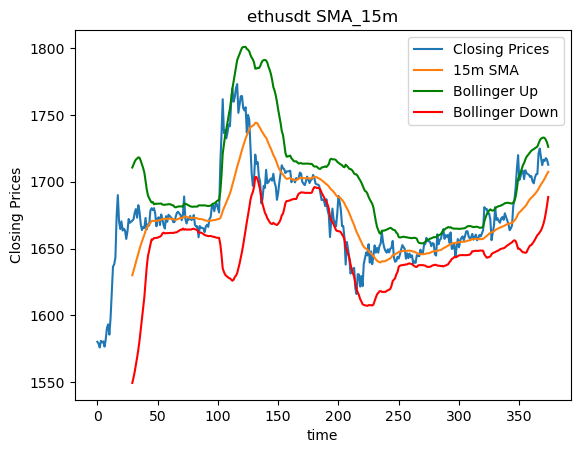

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()

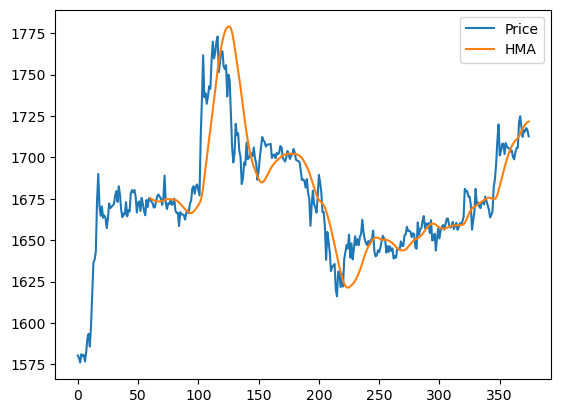

In [17]:
def hma(close, period):
    half_length = period // 2
    sqrt_length = int(np.sqrt(period))

    wma1 = ta.trend.wma_indicator(close, half_length)
    wma2 = ta.trend.wma_indicator(close, period)
    wma_diff = 2 * wma1 - wma2
    hma = ta.trend.wma_indicator(wma_diff, sqrt_length)
    
    return hma

period = 55
df['HMA'] = hma(df['Close'], period)

# plot the HMA and the price data
fig, ax = plt.subplots()
ax.plot(df['Close'], label='Price')
ax.plot(df['HMA'], label='HMA')
ax.legend()
plt.show()

In [18]:
print(df)

              Close_Time     Open    Close     High      Low      Volume  \
0    2023-03-13 19:14:59  1583.56  1580.33  1586.55  1579.97   6803.2882   
1    2023-03-13 19:29:59  1580.33  1579.00  1582.00  1574.67   7992.4032   
2    2023-03-13 19:44:59  1578.99  1576.07  1580.34  1574.72   3914.0760   
3    2023-03-13 19:59:59  1576.06  1581.07  1584.31  1575.32   6427.4574   
4    2023-03-13 20:14:59  1581.07  1579.85  1584.00  1573.67   6798.0922   
..                   ...      ...      ...      ...      ...         ...   
370  2023-03-17 15:44:59  1712.44  1716.46  1717.56  1712.27   7907.6306   
371  2023-03-17 15:59:59  1716.45  1715.59  1716.70  1713.92  11290.1344   
372  2023-03-17 16:14:59  1715.59  1717.70  1722.47  1713.20  14094.6341   
373  2023-03-17 16:29:59  1717.71  1716.46  1721.21  1712.58   8800.1704   
374  2023-03-17 16:44:59  1716.45  1712.75  1717.31  1710.44   5896.2171   

             sma         bb_u         bb_m         bb_l        rsi   c1_1  \
0         